In this notebook we are going to simulate three different paradigms for localizing face responsive areas. We have five categories

1. Faces
2. Bodies
3. Scenes
4. Objects
5. Scrambled objects

We assume we are interested in contrasting for example faces vs. all the other categories. 

We will test out the following paradigms:

1. Intermixed trials: completely randomized short event-related trials, with sequence order generated using Aguirre's Type1-Index1 sequences (see https://cfn.upenn.edu/aguirre/wiki/public:t1i1_sequences)
2. A paradigm similar to that used by Pitcher, ..., Kanwisher, 2011, with all categories shown in one block with no jitter, followed by a fixation cross, and the same sequence in reverse order.
3. A standard block design with on/off stimulation.

In [1]:
# Import code to evaluate efficiency of the sequences
from evalseqshard import EvaluateSeqshard, vec2sim

# import other code
import numpy as np
from scipy.spatial.distance import squareform

In [2]:
# let's store the designs here
designs = dict()

# Intermixed trials

In [4]:
# define parameters
par = {
    'N': 6,  # number of trial types
    'perms': 1000,  # how many permutations to compute
    'TrialDuration': 1.5,  # duration of the trials in seconds
    'BlankLength': 1,  # leave this as it is (or see evalseqshard.py)
    'doubleblanks': False,  # leave this as it is (or see evalseqshard.py)
    'target': 0,  # leave this as it is (or see evalseqshard.py)
    'numSeqs': 100  # number of sequences to output
}

We are going to make a fake similarity matrix because each of our stimuli correspond to a different category

In [5]:
mat = np.ones((5, 5))
np.fill_diagonal(mat, 0.)

In [6]:
# let's visualize the similarity matrices
%matplotlib inline
from matplotlib import pyplot as plt

And these are the similarity matrices

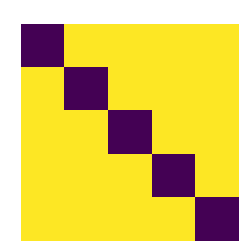

In [7]:
fig, ax = plt.subplots(1, 1)
ax.matshow(mat)
ax.set_axis_off()

In [8]:
# Now compute the sequences (it can take a while given the number of permutations)
# set seed to get same sequence across runs
np.random.seed(485)
result = EvaluateSeqshard(par, mat[..., None])

evalseqshard.py:136: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  EndogenousFilter=hstack((EndogenousFilter, array(zeros((EndoLength-EndogenousFilter.size))).T.flatten(1)))


In [9]:
seq = result['BestSeqs']

In [10]:
seq.shape

(36, 100)

So each stimulus is repeated 6 times. We have a total of 12 stimuli for category, so we need to repeat it twice, that is picking up two sequences that start with the same label type.

In [11]:
def augment_sequence(sequence, all_sequences, nrep):
    """
    Given a sequence, it returns a new sequence of length len(sequence)*nrep by
    appending compatible sequences from all_sequences
    
    Parameters
    ----------
    sequence : array (n_trials)
    all_sequences : array (n_trials, n_sequences)
    nrep : int
    
    Returns
    -------
    augmented_sequence : array (nrep * ntrials)
    """
    end_trial_type = sequence[-1]
    new_sequences = [sequence]
    iseq = 1
    for seq in all_sequences.T:
        if iseq >= nrep:
            break
        if np.array_equal(seq, sequence):
            continue
        if seq[0] == end_trial_type:
            new_sequences.append(seq)
            iseq += 1
    return np.hstack(new_sequences)

In [12]:
def make_pulses(onsets, durations, stimuli, sfreq=10):
    run_len = onsets[-1] + durations[-1]
    time = np.arange(0, run_len * sfreq)
    n_stimuli = len(np.unique(stimuli))
    pulses = np.zeros((n_stimuli, time.shape[0]))

    for trial_type, dur, onset in zip(stimuli, durations, onsets):
        istart = int(onset * sfreq)
        iend = int(istart + dur * sfreq)
        pulses[trial_type, istart:iend] = 1.
    return pulses

In [13]:
def plot_design(onsets, durations, stimuli, TR=1., sfreq=10):
    run_len = onsets[-1] + durations[-1]
    time = np.arange(0, run_len * sfreq)

    pulses = make_pulses(onsets, durations, stimuli, sfreq=sfreq)
        
    fig, axs = plt.subplots(6, 1, figsize=(12, 6), sharex=True)
    for istim, (pulse, ax) in enumerate(zip(pulses, axs.flat)):
        ax.plot(np.linspace(0, run_len, len(time)), pulse)
        # add a bar at every tr
        if TR:
            for tr in np.arange(0, run_len, TR):
                ax.vlines(tr, ymin=0, ymax=1, color='lightgray', alpha=0.5, zorder=0)
        ax.set_ylabel("Stim {0}".format(istim))
    ax.set_xlim(0, run_len)
    plt.tight_layout()
    return fig

In [14]:
def get_duration(seconds):
    return('{0:02.0f}:{1:02.2f}'.format(*divmod(seconds, 60)))

In [15]:
nruns = 4
# now we want to generate 4 sequences, each starting with a different stimulus 
# type so that we don't get the same sequences
stim_types = range(1, 6)
rng = np.random.RandomState(42)
rng.shuffle(stim_types)

run_sequence = []
for s in stim_types[:nruns]:
    which_start_seq = np.where(seq[0, :] == s)[0][0]
    run_sequence.append(augment_sequence(seq[:, which_start_seq], seq, 4).astype(int))
run_sequence = np.array(run_sequence)

In [16]:
# some default params
stim_duration = 1.5
# add fixation at beginning and end
pre_fix = post_fix = 10.

In [17]:
ntrials_run = run_sequence.shape[1]
onsets = []
durations = []
stimuli = []

for irun in range(nruns):
    d = stim_duration * np.ones(ntrials_run)
    # add fixation at beginning and end
    d = np.hstack((pre_fix, d, post_fix))
    o = np.arange(run_sequence.shape[1]) * stim_duration + pre_fix
    # add fixation
    o = np.hstack((0, o, o[-1] + stim_duration))
    if onsets:
        o += onsets[-1] + durations[-1]
    onsets.extend(o)
    durations.extend(d)
    stimuli.extend(np.hstack((0, run_sequence[irun], 0)))
assert(len(stimuli) == len(durations))
assert(len(durations) == len(onsets))

So this is how it looks like whenever we don't have any jitter

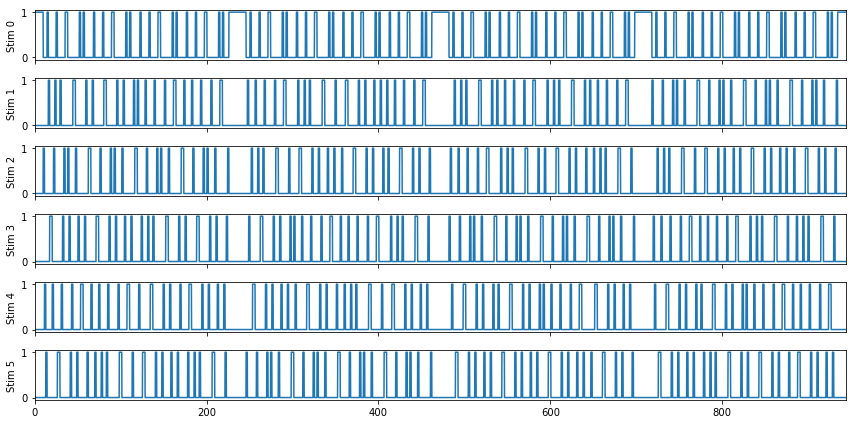

In [18]:
plot_design(onsets, durations, stimuli, TR=None);

# We can use AFNI's make_random_timing to add random jitters

Now let's try using AFNI's `make_random_timing.py`.

In [19]:
onsets_afni = np.loadtxt('afni_rand_times_01_class.1D')
# augment the onsets with beginning and end fixation cross
onsets_afni = np.hstack((
    np.zeros((nruns, 1)), 
    onsets_afni, 
    onsets_afni[:, -1][:, None] + stim_duration)
)

# now we can flatten it
onsets_afni_ = []
for i in range(nruns):
    o = onsets_afni[i]
    if onsets_afni_:
        o += onsets_afni_[-1] + post_fix
    onsets_afni_.extend(o)
onsets_afni = np.array(onsets_afni_)
assert(np.all(np.diff(onsets_afni) > 0))

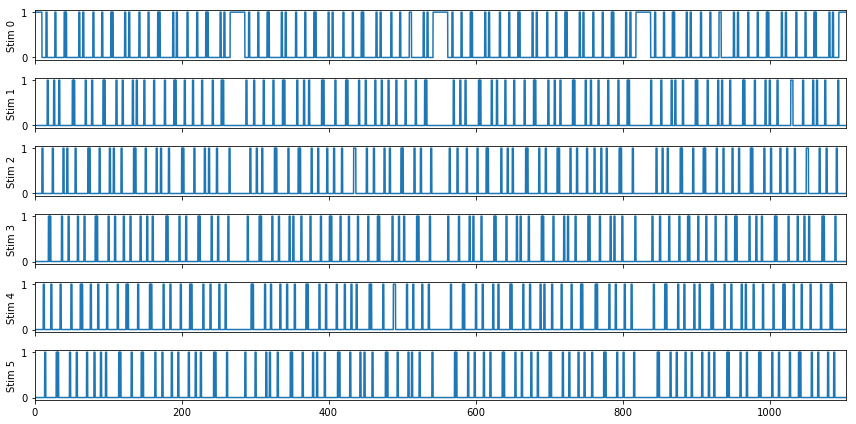

In [20]:
plot_design(onsets_afni, durations, stimuli, TR=None);

In [22]:
# store designs
for lbl, ons in zip(['intermixed-nojitter', 'intermixed-afnijitter'], 
                       [onsets, onsets_afni]):
    designs[lbl] = (ons, durations, stimuli)

# Standard Kanwisher

So here each category is presented continuosly, without jitter, with some fixation in between. From the paper

> Each functional run contained three 18-s rest blocks, at the beginning,middle, and end of the run, during which a series of six uniform colorfields were presented for 3 s each (these colorfields were designed tomaintain the interest of children, for whom the dynamic localizer wasoriginally designed, while approximating afixation baseline conditionby avoiding any pattern visual input). Participants were instructed towatch the movies and static images but were not asked to performany overt task.

> Each run contained two sets offive consecutive stimulus blocks(faces, bodies, scenes, objects or scrambled objects) sandwichedbetween these rest blocks, to make two blocks per stimulus categoryper run. Each block lasted 18 s and contained stimuli from one of the five stimulus categories. The order of stimulus category blocks in eachrun was palindromic (e.g.,fixation, faces, objects, scenes, bodies,scrambled objects,fixation, scrambled objects, bodies, scenes, objects,faces,fixation) and was randomized across runs. 

Let's build one of these runs. In our case we have 12 clips per category, lasting each 1.5 seconds, thus a total of 18s for each block.

In [23]:
duration = 1.5  # duration of each clip
n_stim_category = 12
n_categories = 5  # without counting the fixation
n_fixations = 3
len_fixation = int(duration * n_stim_category)
n_repetitions_block = 2

len_run_s = len_fixation * n_fixations + duration * n_stim_category * n_categories * n_repetitions_block
print("Run duration: {0}".format(get_duration(len_run_s)))

Run duration: 03:54.00


In [24]:
param = {
    'duration': 1.5,
    'n_stim_category': 12,
    'n_categories': 5
}

In [25]:
def build_kanwisher_run(rng, param):
    # now let's build it
    duration = param['duration']
    n_stim_category = param['n_stim_category']
    n_categories = param['n_categories']
    
    block1_order = np.arange(1, n_categories + 1)
    rng.shuffle(block1_order)
    block2_order = block1_order[::-1]  # as in the original paper, palindromic
    
    onsets = []
    durations = []
    stimuli = []
    t = 0
    phase = ['fixation', block1_order, 'fixation', block2_order, 'fixation']
    for ph in phase:
        if isinstance(ph, str):
            stimuli.append(0)
            onsets.append(t)
            durations.append(len_fixation)
            t += len_fixation
        else:
            for stim_type in ph:
                onsets.extend(np.arange(n_stim_category)*duration + t)
                durations.extend(np.ones(n_stim_category)*duration)
                stimuli.extend(np.ones(n_stim_category, dtype=int)*stim_type)
                t += n_stim_category*duration
    return np.array(onsets), np.array(durations), stimuli

In [26]:
nruns = 4
onsets = []
durations = []
stimuli = []

for _ in range(nruns):
    o, d, s = build_kanwisher_run(rng, param)
    # append to last run
    if onsets:
        o += onsets[-1] + durations[-1]
    onsets.extend(o)
    durations.extend(d)
    stimuli.extend(s)

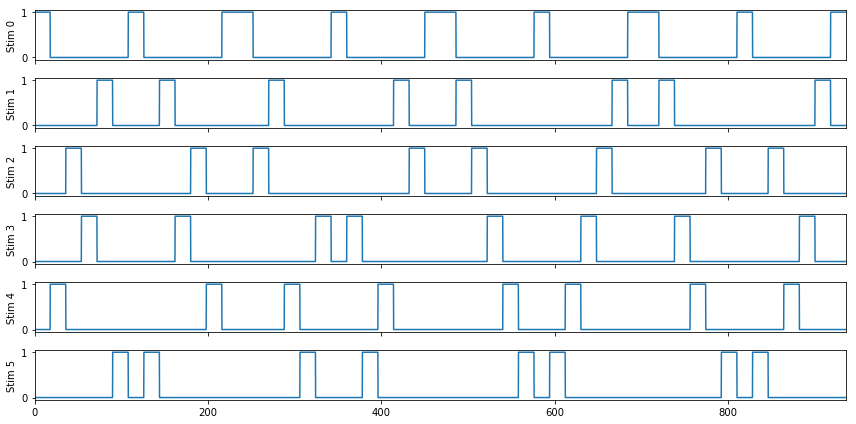

In [27]:
plot_design(onsets, durations, stimuli, TR=None);

In [28]:
designs['kanwisher'] = (onsets, durations, stimuli)

# Standard Block Design

So here we have one repetition of each category in each run, randomized across runs. It's a standard on/off block design.

In [29]:
def build_block_run(rng, param):
    # now let's build it
    duration = param['duration']
    n_stim_category = param['n_stim_category']
    n_categories = param['n_categories']
    
    block_order = np.arange(1, 6)
    rng.shuffle(block_order)

    onsets = []
    durations = []
    stimuli = []

    t = 0
    # build template
    phase = []
    for stim_type in block_order:
        phase.append('fixation')
        phase.append([stim_type] * n_stim_category)
    phase.append('fixation')

    for ph in phase:
        if isinstance(ph, str):
            stimuli.append(0)
            onsets.append(t)
            durations.append(len_fixation)
            t += len_fixation
        else:
            len_ph = len(ph)
            onsets.extend(np.arange(len_ph)*duration + t)
            durations.extend(np.ones(len_ph)*duration)
            stimuli.extend(np.ones(len_ph, dtype=int)*ph[0])
            t += len_ph*duration
    return np.array(onsets), np.array(durations), stimuli

In [30]:
nruns = 4
onsets = []
durations = []
stimuli = []

for _ in range(nruns):
    o, d, s = build_block_run(rng, param)
    # append to last run
    if onsets:
        o += onsets[-1] + durations[-1]
    onsets.extend(o)
    durations.extend(d)
    stimuli.extend(s)

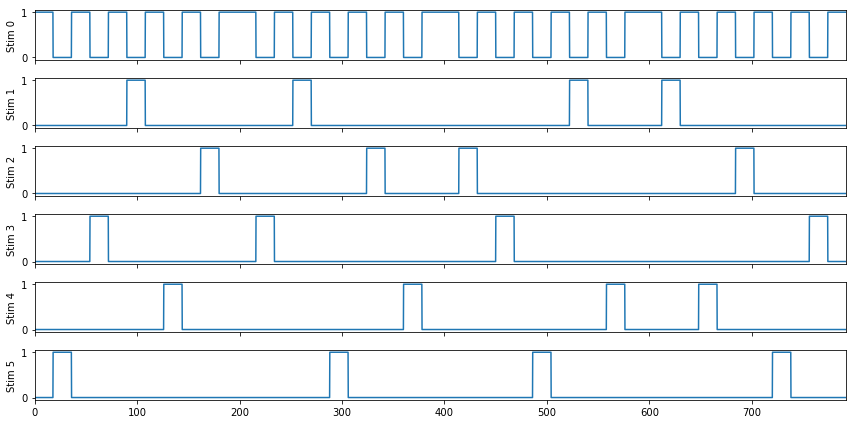

In [31]:
plot_design(onsets, durations, stimuli, TR=None);

In [32]:
designs['block'] = (onsets, durations, stimuli)

# Now we can simulate some data

In [33]:
from mvpa2.misc.data_generators import simple_hrf_dataset
from mvpa2.misc.support import Event
from mvpa2.datasets.eventrelated import fit_event_hrf_model

In [34]:
def generate_events(onsets, durations, stimuli, intensities, skip=[0]):
    # convert onsets and duration into pymvpa format
    events = [
        Event(onset=o, duration=d, intensity=intensities[s], condition=s) 
        for o, d, s in zip(onsets, durations, stimuli) if s not in skip]
    return events

In [35]:
def simulate_data(events, tr=1.0, noise_level=1., signal_level=1.):
    ds = simple_hrf_dataset(events=events, tr=tr, noise_level=noise_level, signal_level=signal_level)
    ds.sa['time'] = np.arange(0, ds.nsamples, tr)
    return ds[:, 0]

In [36]:
def compute_contrast_value(ds, events, contrast):
    glm = fit_event_hrf_model(ds, events, time_attr='time', 
                              design_kwargs=dict(drift_model='blank'),
                              glmfit_kwargs=dict(model='ols'),
                              condition_attr='condition', 
                              return_model=True)
    model = glm.a.model
    c = model.contrast(contrast)
    return c.stat()[0]

In [37]:
face_vs_other = [4, -1, -1, -1, -1, 0]

In [38]:
def perform_simulation(events, contrast, snr=1., nsim=100):
    tvals = []
    for _ in range(nsim):
        ds = simulate_data(events, signal_level=snr)
        t = compute_contrast_value(ds, events, contrast)
        tvals.append(t)
    # return mean and standard deviation
    return np.mean(tvals), np.std(tvals)

In [39]:
def generate_intensities(facerest_ratio=1.):
    intensities = {
        0: 0,
        1: facerest_ratio,
        2: facerest_ratio - facerest_ratio/10,
        3: 1,
        4: 1,
        5: 1
    }
    return intensities

In [40]:
def compute_grid(onsets, durations, stimuli, faceother_ratios, snrs, nsim=100):
    out = []
    for faceother_ratio in faceother_ratios:
        print("Running for faceother_ratio {0}".format(faceother_ratio))
        intensities = generate_intensities(faceother_ratio)
        events = generate_events(onsets, durations, stimuli, intensities)
        out_snrs = []
        for snr in snrs:
            #print("   Running snr {0}".format(snr))
            out_snrs.append(perform_simulation(events, face_vs_other, snr=snr, nsim=nsim))
        out.append(out_snrs)
    return np.array(out)

In [41]:
snrs = np.linspace(0.1, 4, 10)
faceother_ratios = np.linspace(1, 4, 10)

In [42]:
from joblib import Parallel, delayed

In [43]:
designs.keys()

['intermixed-afnijitter', 'intermixed-nojitter', 'block', 'kanwisher']

In [44]:
# design_keys = designs.keys()
design_keys = ['kanwisher', 'block', 'intermixed-afnijitter']
grids = Parallel(n_jobs=4, verbose=20)(delayed(compute_grid)(*designs[key], faceother_ratios=faceother_ratios, snrs=snrs) for key in design_keys)

Running for faceother_ratio 1.0
Running for faceother_ratio 1.0
Running for faceother_ratio 1.0
Running for faceother_ratio 1.33333333333
Running for faceother_ratio 1.33333333333
Running for faceother_ratio 1.33333333333
Running for faceother_ratio 1.66666666667
Running for faceother_ratio 1.66666666667
Running for faceother_ratio 2.0
Running for faceother_ratio 1.66666666667
Running for faceother_ratio 2.33333333333
Running for faceother_ratio 2.0
Running for faceother_ratio 2.0
Running for faceother_ratio 2.66666666667
Running for faceother_ratio 2.33333333333
Running for faceother_ratio 3.0
Running for faceother_ratio 2.33333333333
Running for faceother_ratio 3.33333333333
Running for faceother_ratio 2.66666666667
Running for faceother_ratio 2.66666666667
Running for faceother_ratio 3.66666666667
Running for faceother_ratio 3.0
Running for faceother_ratio 4.0
Running for faceother_ratio 3.0


[Parallel(n_jobs=4)]: Done   2 out of   3 | elapsed: 13.0min remaining:  6.5min


Running for faceother_ratio 3.33333333333
Running for faceother_ratio 3.33333333333
Running for faceother_ratio 3.66666666667
Running for faceother_ratio 3.66666666667
Running for faceother_ratio 4.0
Running for faceother_ratio 4.0


[Parallel(n_jobs=4)]: Done   1 out of   3 | elapsed: 18.1min remaining: 36.1min
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 18.5min finished


In [45]:
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

In [46]:
np.savez('grids_mixed_selectivity.npz', {'grids': grids})

# Results
Here we are plotting simulations after 100 repetitions of the average t-value for the contrast "face vs. other" changing the ratio of response Face vs. Other categories, and changing SNR.

Our metric is thus the t-value of the specific contrast we are interested in.

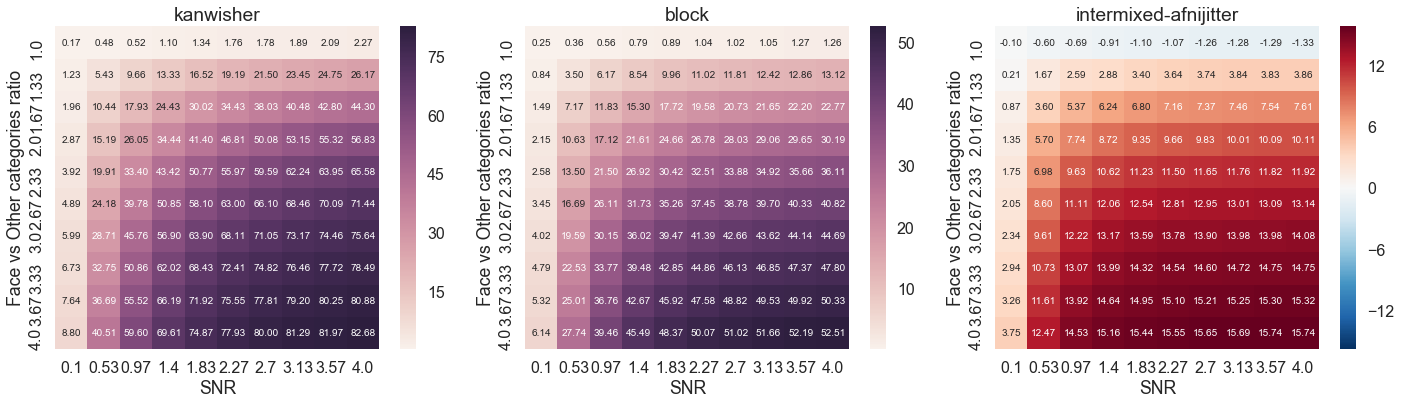

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for lbl, grid, ax in zip(design_keys, grids, axs.flat):
    sns.heatmap(grid[..., 0], annot=True, fmt='.2f',
                yticklabels=np.round(faceother_ratios, 2),
                xticklabels=np.round(snrs, 2),
                annot_kws={"size": 10},
                ax=ax)
    ax.set_xlabel('SNR')
    ax.set_ylabel('Face vs Other categories ratio')
    ax.set_title(lbl)
plt.tight_layout()

So it seems like the design implemented in Pitcher et al. is the more robust of the three. I think this is because

1. there are more repetitions of categories within each run;
2. each block is 18s long, and the canonical HRF gets to baseline after ~20s, so it's optimized to detect these changes;
3. and finally, even though the categories are one after the other, if a voxel is strongly responsive to one of the categories, the difference will still be higher (see below)

In [81]:
sfreq = 10
onsets, durations, stimuli = designs['kanwisher']
intensities = generate_intensities(2.)
events = generate_events(onsets, durations, stimuli, intensities)

In [87]:
pulse = np.zeros(int(events[-1]['duration'] + events[-1]['onset'] + 10) * sfreq)

In [88]:
for e in events:
    start = int(e['onset'] * sfreq)
    end = start + int(e['duration'] * sfreq)
    if e['condition'] != 0:
        pulse[start:end] = e['intensity']

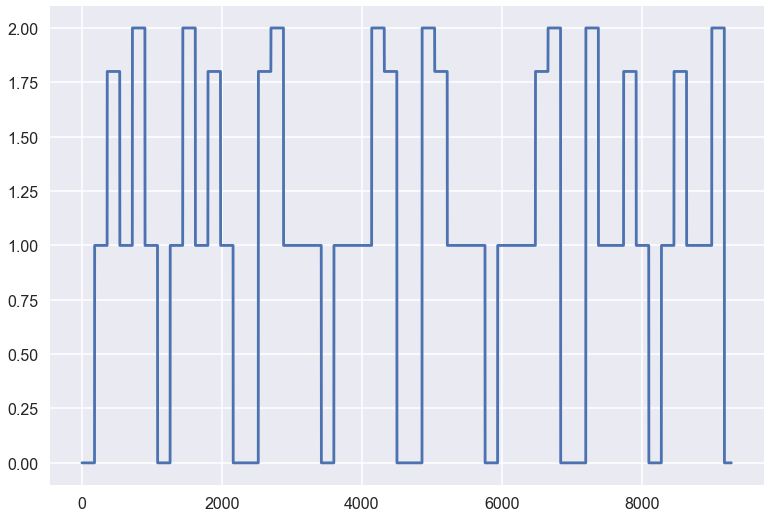

In [91]:
# so this is our design, and the peaks are the responses to faces. now we convolve this with the standard HRF
plt.plot(pulse);

In [99]:
def hrf(t, q=5):
    # from afni 3dDeconvolve
    # t^q * exp(-t) /(q^q*exp(-q))
    return t**q * np.exp(-t)/(q**q*np.exp(-q))

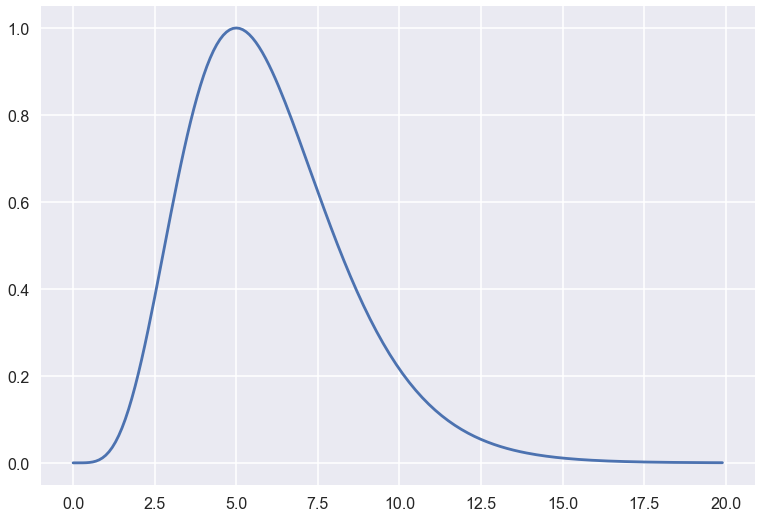

In [100]:
x = np.arange(0, 20, 0.1)
y = hrf(x)
plt.plot(x, y);

In [101]:
pulse_conv = np.convolve(pulse, y, mode='full')

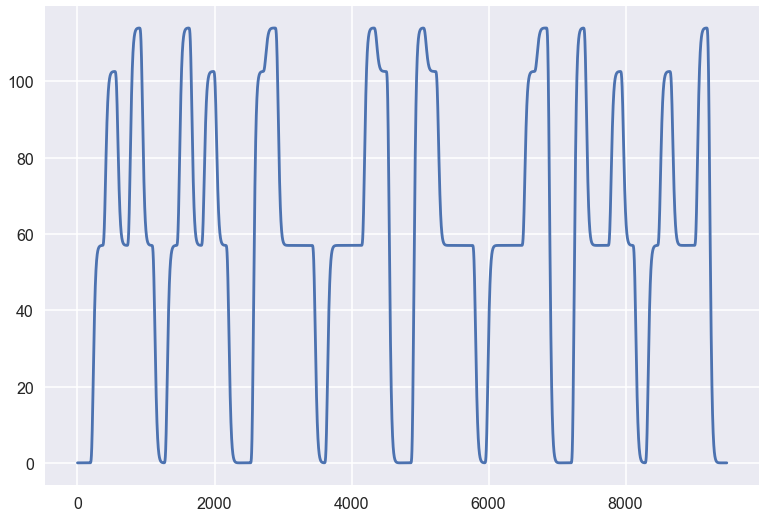

In [106]:
plt.plot(pulse_conv)